In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
## First we will inspect the data to facilitate the following parts

# Inspector and function dependencies
from sqlalchemy import create_engine, inspect, func

# using inspector to get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])
precipitation_df.set_index('date', inplace = True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
print(precipitation_df)

# we get some NaN values that we need to get rid of
precipitation_df.dropna(inplace=True)
print(precipitation_df)


            precipitation
date                     
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24            NaN
2016-08-24           1.22
...                   ...
2017-08-22           0.50
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.45

[2223 rows x 1 columns]
            precipitation
date                     
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24           1.22
2016-08-24           2.15
...                   ...
2017-08-22           0.50
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.45

[2015 rows x 1 columns]


Text(0.5, 0, 'Date')

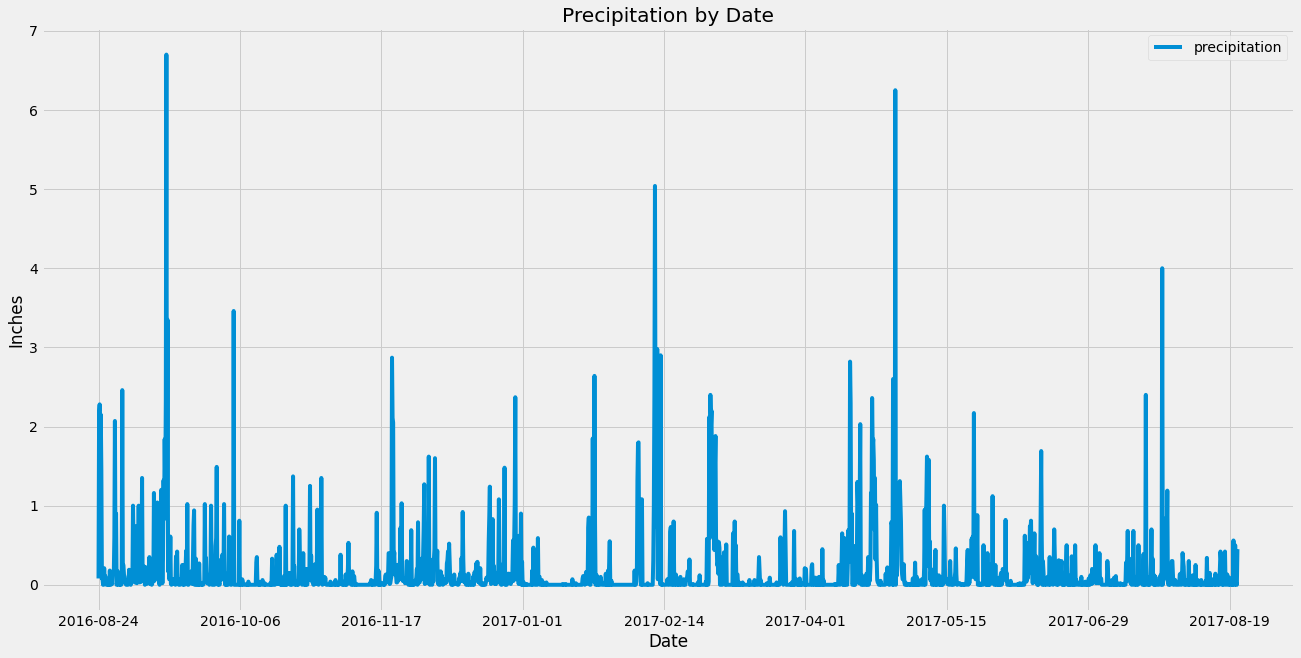

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_df.plot(ax = ax, x_compat = True)


plt.title("Precipitation by Date")
plt.ylabel("Inches")
plt.xlabel("Date")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9)]

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active= 'USC00519281'

# we are getting the lowest temperature
temp_lowest = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == most_active).all()
temp_lowest

[(54.0)]

In [19]:
# we are getting the highest temperature
temp_highest = session.query(func.max(Measurement.tobs)).\
filter(Measurement.station == most_active).all()
temp_highest

[(85.0)]

In [20]:
# we are getting the average temperature
temp_average = session.query(func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active).all()
temp_average

[(71.66378066378067)]

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#putting the results in a dataframe for plotting
temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])

temp_observation_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


Text(0.5, 1.0, 'Last 12 months of Temperature')

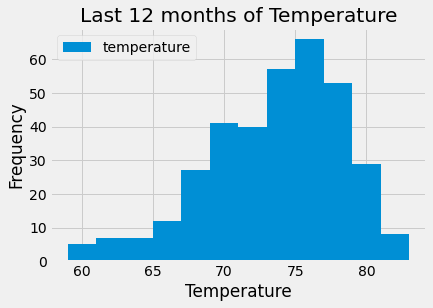

In [22]:
# histogram with results
fig, ax = plt.subplots()
temp_observation_df.plot.hist(bins = 12, ax = ax)

plt.xlabel("Temperature")
plt.title("Last 12 months of Temperature")

# Close session

In [23]:
# Close Session
session.close()